In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

np.random.seed(42)

In [2]:
from preprocessing.getdata import *
df = get_csvdata()
dfTrain, dfTest, y_train, y_test = train_test_split(df, df['CDR'], stratify = df['CDR'], random_state=42)

In [3]:
X_test = get_slices(dfTest['ID'], dim=2, m=90)
X_test = X_test.reshape((len(X_test),-1))

d=2
N=0

X_train = get_slices(dfTrain['ID'], N=N, d=d, dim=2, m=90)
y_train = y_train.repeat(1+2*N)
X_train = X_train.reshape((len(X_train),-1))

In [11]:
#model = SVC()
model = ExtraTreesClassifier()
model.fit(X_train, y_train)

ExtraTreesClassifier()

In [4]:
param_grid = {'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']}

gs = GridSearchCV(SVC(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train, y_train)
gs.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.607 total time=   1.2s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.519 total time=   1.2s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.481 total time=   1.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.481 total time=   1.6s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   1.6s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.481 total time=   1.6s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.481 total time=   1.7s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.481 total time=   1.7s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.593 total time=   1.4s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.741 total time=   1.4s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.500 total time=   1.4s
[CV 3/5] END ....C=0.1, gamma=1, kernel=sigmoid

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [27]:
param_grid = {'n_estimators': [50,100,200],
                'criterion': ['gini'],
                'max_depth': [20],
                'min_samples_split': [60],
                'min_samples_leaf': [2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train, y_train)
gs.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.717 total time=   8.5s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.518 total time=   8.6s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.679 total time=   8.6s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.696 total time=   8.7s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.538 total time=   8.8s
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.697 total time=  10.9s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.518 total time=  10.9s


{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 60,
 'n_estimators': 50}

In [5]:
model = gs.best_estimator_

In [6]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)
accuracy_score(y_train, model.predict(X_train))

0.5652173913043478


1.0

accuracy:  0.65
recall:  0.74
precision:  0.63


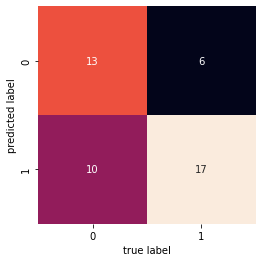

In [11]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred).round(2))
print('recall: ' , recall_score(y_test, y_pred).round(2))
print('precision: ' , precision_score(y_test, y_pred).round(2))